In [1]:
# IP USED THROUGHOUT THE ASSIGNMENT
hostip = "172.22.32.1"

<IPython.core.display.Javascript object>


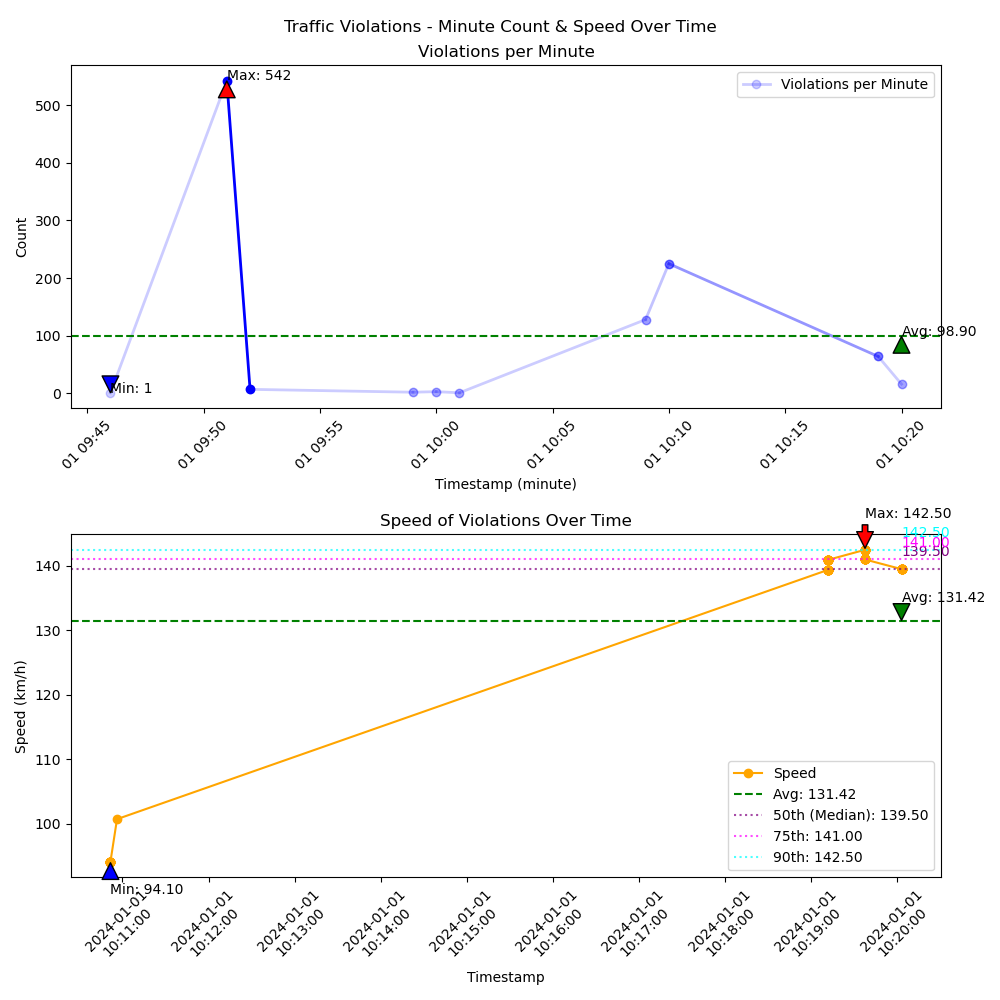

[INFO] Consuming and plotting...


/tmp/ipykernel_49890/3595707675.py:231: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


In [ ]:
import json
from kafka3 import KafkaConsumer
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import matplotlib.dates as mdates
import numpy as np
from typing import List

# Kafka setup
topic = "mongo_plot_stream"
kafka_server = f"{hostip}:9092"

# instantiate kafka consumer
consumer = KafkaConsumer(
    topic,
    bootstrap_servers=[kafka_server],
    auto_offset_reset='earliest',
    value_deserializer=lambda m: json.loads(m.decode('utf-8'))
)

# For Jupyter: enable interactive plotting
%matplotlib notebook
plt.ion()

# Setup figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
fig.suptitle("Traffic Violations - Minute Count & Speed Over Time")

# Initialize containers
minute_counts = Counter()  # COMMENT: changed aggregation to per-minute
timestamp_container = []
speed_container = []
previous_interval_count = 0  # COMMENT: renamed from previous_day_count
speed_rolling_avg = []
# For rolling average calculation
rolling_window = 10
sparsity_threshold = 2  # COMMENT: Threshold for highlighting sparsity (adjust as needed)

# Utility functions with min/max/avg for count
def annotate_count(ax, x_data, y_data):
    """
    This function is to annotate for the plot timestamp time-series againts Count of violation.
    Input:
        - ax
        - x_data (list): time-series in of timestamp
        - y_data (list): container of counts
    Output:
        - annotated mininum, maximum, and average point
    """
    if not y_data:
        return
    min_y = min(y_data)
    max_y = max(y_data)
    avg_y = sum(y_data) / len(y_data)

    if x_data:
        xpos_min = x_data[y_data.index(min_y)]
        xpos_max = x_data[y_data.index(max_y)]
        xpos_avg = x_data[-1]

        ax.annotate(f'Min: {min_y}', xy=(xpos_min, min_y), xytext=(xpos_min, min_y - 1),
                    arrowprops=dict(facecolor='blue', shrink=0.05))
        ax.annotate(f'Max: {max_y}', xy=(xpos_max, max_y), xytext=(xpos_max, max_y + 1),
                    arrowprops=dict(facecolor='red', shrink=0.05))
        ax.axhline(y=avg_y, color='green', linestyle='--', label=f'Avg: {avg_y:.2f}')
        ax.annotate(f'Avg: {avg_y:.2f}', xy=(xpos_avg, avg_y), xytext=(xpos_avg, avg_y + 1),
                    arrowprops=dict(facecolor='green', shrink=0.05))

def annotate_speed(ax, x_data:List, y_data:List):
    """
    This function is to annoate for the plot timestamp time-series againts Speed.
    Input:
        - ax
        - x_data (list): time-series in of timestamp
        - y_data (list): container of speed
    Output:
        - annotated mininum, maximum, and average point
        - annotated dynamic percentile (50. 75, 90)
    """
    if not y_data:
        return
    min_y = min(y_data)
    max_y = max(y_data)
    avg_y = sum(y_data) / len(y_data)

    if x_data:
        xpos_min = x_data[y_data.index(min_y)]
        xpos_max = x_data[y_data.index(max_y)]
        xpos_avg = x_data[-1]

        ax.annotate(f'Min: {min_y:.2f}', xy=(xpos_min, min_y), xytext=(xpos_min, min_y - 5),
                    arrowprops=dict(facecolor='blue', shrink=0.05))
        ax.annotate(f'Max: {max_y:.2f}', xy=(xpos_max, max_y), xytext=(xpos_max, max_y + 5),
                    arrowprops=dict(facecolor='red', shrink=0.05))
        ax.axhline(y=avg_y, color='green', linestyle='--', label=f'Avg: {avg_y:.2f}')
        ax.annotate(f'Avg: {avg_y:.2f}', xy=(xpos_avg, avg_y), xytext=(xpos_avg, avg_y + 3),
                    arrowprops=dict(facecolor='green', shrink=0.05))

        # Percentile lines using np on the data list we have right now
        percentiles = np.percentile(y_data, [50, 75, 90])
        labels = ["50th (Median)", "75th", "90th"]
        # color the percentile lines
        colors = ['purple', 'magenta', 'cyan']
        # loop through all together to synchronize everything together
        for p, label, color in zip(percentiles, labels, colors):
            ax.axhline(y=p, color=color, linestyle=':', alpha=0.7, label=f'{label}: {p:.2f}')
            ax.annotate(f'{p:.2f}', xy=(x_data[-1], p), xytext=(x_data[-1], p + 2), color=color)


print("[INFO] Consuming and plotting...")
plt.ion()

while True:
    for message in consumer:
        event = message.value

        violations = sorted(
            event.get("violations", []),
            key=lambda v: v.get("timestamp_start", {}).get("$date", "")
        )

        for violation in violations:
            speed = violation.get("measured_speed")
            ts_raw = violation.get("timestamp_start", {})
            ts_str = ts_raw.get("$date")
            if not ts_str:
                continue
            ts_str = ts_str.replace("Z", "+00:00")

            try:
                dt_obj = datetime.fromisoformat(ts_str)
            except ValueError:
                continue

            # Update for count plot (top)
            dt_minute = dt_obj.replace(second=0, microsecond=0)  # COMMENT: truncate to minute
            minute_counts[dt_minute] += 1  # COMMENT: use minute_counts instead of day_counts

            if len(minute_counts) > 10:
                latest_minutes = sorted(minute_counts.keys())[-10:]  # COMMENT: keep only last 10 minutes
                minute_counts = Counter({k: minute_counts[k] for k in latest_minutes})

            # Update for speed plot (bottom)
            timestamp_container.append(dt_obj)
            speed_container.append(float(speed))
            if len(timestamp_container) > 100:
                timestamp_container = timestamp_container[-100:]
                speed_container = speed_container[-100:]
            if len(speed_container) >= rolling_window:
                speed_rolling_avg.append(np.mean(speed_container[-rolling_window:]))
            else:
                speed_rolling_avg.append(np.mean(speed_container))

        # sort global container
        pairs = sorted(zip(timestamp_container, speed_container), key=lambda p: p[0])
        timestamp_container, speed_container = map(list, zip(*pairs))

        # Plotting
        ax1.clear()
        ax2.clear()

        # Violations per Minute
        minutes_sorted = sorted(minute_counts.keys())  # COMMENT: renamed from days_sorted
        counts_sorted = [minute_counts[m] for m in minutes_sorted]

        # Highlight sparsity
        if counts_sorted:
            max_count = max(counts_sorted)
            for i in range(len(counts_sorted) - 1):
                alpha = 1.0 if max_count == 0 else max(0.2, counts_sorted[i] / max_count)
                linewidth = 2 if counts_sorted[i] > 0 else 0.5
                ax1.plot(minutes_sorted[i:i+2], counts_sorted[i:i+2], marker='o', linestyle='-', color='blue', alpha=alpha, linewidth=linewidth)
            # Plot the last point
            alpha_last = 1.0 if max_count == 0 else max(0.2, counts_sorted[-1] / max_count)
            linewidth_last = 2 if counts_sorted[-1] > 0 else 0.5
            ax1.plot(minutes_sorted[-1], counts_sorted[-1], marker='o', color='blue', alpha=alpha_last, linewidth=linewidth_last)


        annotate_count(ax1, minutes_sorted, counts_sorted)

        ax1.set_title("Violations per Minute")  # COMMENT: updated title
        ax1.set_xlabel("Timestamp (minute)")  # COMMENT: updated xlabel
        ax1.set_ylabel("Count")
        ax1.tick_params(axis='x', rotation=45)
        ax1.legend(["Violations per Minute"]) # Added legend

        if len(counts_sorted) > 1 and counts_sorted[-1] > 2 * previous_interval_count and previous_interval_count > 0:
            ax1.annotate('Spike!', xy=(minutes_sorted[-1], counts_sorted[-1]),
                         xytext=(minutes_sorted[-1], counts_sorted[-1] + 2),
                         arrowprops=dict(facecolor='violet', shrink=0.05))
        previous_interval_count = counts_sorted[-1] if counts_sorted else 0  # COMMENT: update previous_interval_count

        # Speed Over TimeStamp
        ax2.plot(timestamp_container, speed_container, marker='o', color='orange', label="Speed")
        #run the function to annotate the speed
        annotate_speed(ax2, timestamp_container, speed_container)
        #label to high speed and low speed if > 150 -> high
        for ts, sp in zip(timestamp_container, speed_container):
            if sp > 150:
                ax2.plot(ts, sp, 'r*', markersize=10,
                         label='High Speed' if 'High Speed' not in ax2.get_legend_handles_labels()[1] else "")
            #if < 10 -> low
            elif sp < 10:
                ax2.plot(ts, sp, 'b*', markersize=10,
                         label='Low Speed' if 'Low Speed' not in ax2.get_legend_handles_labels()[1] else "")

        #annotate a speed spike and drop
        if len(speed_container) > rolling_window and len(speed_rolling_avg) > 1:
            #get current speed
            current_speed = speed_container[-1]
            #get previous rolling average
            prev_avg = speed_rolling_avg[-2]
            #tag spike or drop
            if current_speed > 1.5 * prev_avg:
                ax2.annotate('Speed Spike!', xy=(timestamp_container[-1], current_speed),
                             xytext=(timestamp_container[-1], current_speed + 5),
                             arrowprops=dict(facecolor='lime', shrink=0.05))
            elif current_speed < 0.6 * prev_avg:
                ax2.annotate('Speed Drop!', xy=(timestamp_container[-1], current_speed),
                             xytext=(timestamp_container[-1], current_speed - 5),
                             arrowprops=dict(facecolor='red', shrink=0.05))

        ax2.set_title("Speed of Violations Over Time")
        ax2.set_xlabel("Timestamp")
        ax2.set_ylabel("Speed (km/h)")
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M:%S'))
        ax2.tick_params(axis='x', rotation=45)
        ax2.legend()

        plt.tight_layout()
        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.pause(0.1)

plt.ioff()
plt.show()